In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu

from hatespeech import utils
from hatespeech.keys import items, annotator_race_to_col

%matplotlib inline

In [2]:
#data_path = '/home/psachdeva/data/scaled-facets-multi-50k-v4.feather'
data_path = '~/data/hatespeech/scaled-facets-multi-50k-v4.feather'

In [3]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})

In [4]:
reference_set = data[data['platform'] == 'reference'].copy()

In [5]:
print(f'Number of unique reference set comments: {reference_set["comment_id"].unique().size}')
print(f'Number of samples in reference set: {reference_set.shape[0]}')

Number of unique reference set comments: 70
Number of samples in reference set: 43227


In [6]:
hs_sum = reference_set[items].sum(axis=1)
reference_set['hs_sum'] = hs_sum

In [7]:
reference_bw = reference_set[
    (reference_set[annotator_race_to_col['black']] == 1) | 
    (reference_set[annotator_race_to_col['white']] == 1)
]
reference_bw = utils.filter_comments_targeting_bw(reference_set, threshold=0.5)

In [8]:
reference_bw_targeting_b = reference_bw[reference_bw['target_black']].copy()
reference_bw_targeting_w = reference_bw[~reference_bw['target_black']].copy()

In [9]:
print(f'Number of samples whose annotators are black or white: {reference_bw.shape[0]}')
print(f'Number of samples targeting black identity whose annotators are black or white: {reference_bw_targeting_b.shape[0]}')
print(f'Number of samples targeting white identity whose annotators are black or white: {reference_bw_targeting_w.shape[0]}')
print(f'Number of unique comments targeting black people: {reference_bw_targeting_b["comment_id"].unique().size}')
print(f'Number of unique comments targeting white people: {reference_bw_targeting_w["comment_id"].unique().size}')

Number of samples whose annotators are black or white: 12067
Number of samples targeting black identity whose annotators are black or white: 10952
Number of samples targeting white identity whose annotators are black or white: 1115
Number of unique comments targeting black people: 18
Number of unique comments targeting white people: 2


In [10]:
reference_bw_targeting_b['annotator_race'] = np.where(
    reference_bw_targeting_b[annotator_race_to_col['black']] == 1,
    'black',
    'white')
reference_bw_targeting_w['annotator_race'] = np.where(
    reference_bw_targeting_w[annotator_race_to_col['black']] == 1,
    'black',
    'white')

In [14]:
bw_targeting_b_comments = reference_bw_targeting_b['comment_id'].unique()
bw_targeting_b_counts = reference_bw_targeting_b.groupby(['comment_id', 'annotator_race']).count()
bw_targeting_b_means = reference_bw_targeting_b.groupby(['comment_id', 'annotator_race']).mean()[['hs_sum'] + items]
bw_targeting_b_diffs = bw_targeting_b_means.diff().query("annotator_race == 'white'").droplevel('annotator_race')

In [40]:
reference_bw_targeting_w['comment_id'].unique()

array([20038, 20052], dtype=int32)

In [16]:
p_values = np.zeros((bw_targeting_b_comments.size, 11))

for ii, comment_id in enumerate(bw_targeting_b_comments):
    for jj, item in enumerate(['hs_sum'] + items):
        black_scores = reference_bw_targeting_b[
            (reference_bw_targeting_b['comment_id'] == comment_id) &
            (reference_bw_targeting_b['annotator_race'] == 'black')
        ][item]
        white_scores = reference_bw_targeting_b[
            (reference_bw_targeting_b['comment_id'] == comment_id) &
            (reference_bw_targeting_b['annotator_race'] == 'white')
        ][item]
        p_values[ii, jj] = mannwhitneyu(black_scores, white_scores).pvalue

In [17]:
p_values = pd.DataFrame(data=p_values, columns=['hs_sum'] + items, index=bw_targeting_b_comments)

In [24]:
p_values < 0.05

,hs_sum,sentiment,respect,insult,humiliate,status,dehumanize,violence,genocide,attack_defend,hatespeech
20045,False,False,False,False,True,False,False,False,False,False,False
20057,False,False,False,False,False,True,True,True,False,False,True
20002,False,False,False,False,True,True,False,False,False,False,False
20001,False,True,False,False,True,True,False,False,False,False,False
20012,False,False,False,False,False,True,False,True,False,True,False
20003,False,False,False,False,False,False,False,False,False,False,False
20008,False,False,False,True,False,True,True,False,False,False,False
20006,False,False,False,False,False,True,False,True,False,False,False
20015,True,False,False,True,True,False,False,True,True,False,False
20037,False,False,False,False,False,False,False,False,False,False,False


In [62]:
bw_targeting_b_comments

array([20045, 20057, 20002, 20001, 20012, 20003, 20008, 20006, 20015,
       20037, 20030, 20033, 20032, 20039, 20031, 20043, 20055, 20049],
      dtype=int32)

In [38]:
reference_bw_targeting_b[(reference_bw_targeting_b['comment_id'] == 20008) &
                         (reference_bw_targeting_b['annotator_race'] == 'white')]['status'].value_counts()

1.0    541
0.0    105
Name: status, dtype: int64

In [37]:
reference_bw_targeting_b[(reference_bw_targeting_b['comment_id'] == 20008) &
                         (reference_bw_targeting_b['annotator_race'] == 'black')]['status'].value_counts()

1.0    50
0.0    24
Name: status, dtype: int64

In [43]:
reference_bw_targeting_w[reference_bw_targeting_w['comment_id'] == 20052]['predict_text'].iloc[9]

'It\'s just really pointless and insulting to people who actually experience racism by implying our society is in need of a reminder that being a white person is okay. Because I doubt one genuine look at history would leave anyone wondering if "being white" in the U.S. will be perceived as a problem.  The very concept of on a personal level being okay with the fact you were born with the skin color you were born with is of course not racist. But the statement just makes it seem like white people are at risk to become some sort of outcasts.'

In [12]:
comment_text = reference_set[reference_set['comment_id'].isin(hs_diffs.index)][
    ['comment_id', 'predict_text']
].set_index('comment_id').drop_duplicates().sort_values('comment_id')

In [13]:
final = pd.concat((comment_text, hs_diffs), axis=1)

Text(0, 0.5, 'Hate Speech Sum Difference')

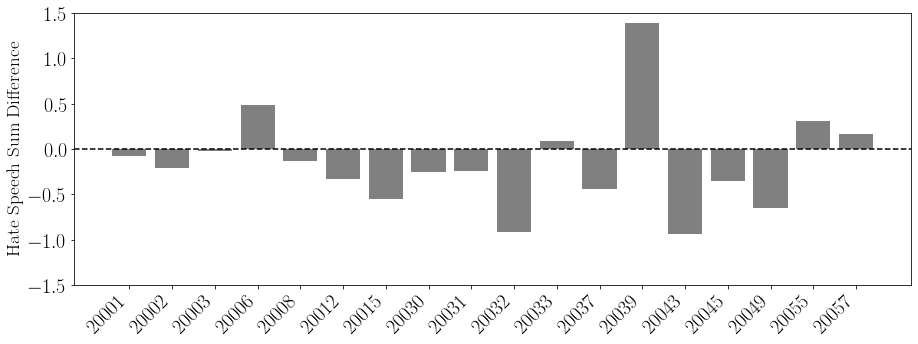

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.bar(x=np.arange(final.shape[0]), height=final['hs_sum'], color='gray')
ax.set_ylim([-1.5, 1.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[0]))
ax.set_xticklabels(final.index,rotation=45, ha='right')
ax.set_ylabel('Hate Speech Sum Difference', fontsize=19)

In [41]:
final.loc[example_comment]['predict_text']

"Black people cant take jokes #bigfacts Here come the I'm racist and downvotes proving this sentiment"

In [34]:
item_strings = ['Sentiment', 'Respect', 'Insult', 'Humiliate', 'Status', 'Dehumanize', 'Violence', 'Genocide', 'Attack/Defend', 'Hate speech']

In [39]:
example_comment = 20039

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[1] - 2), height=final.loc[example_comment].values[2:], color='gray')
ax.set_ylim([-0.05, 0.4])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[1] - 2))
ax.set_xticklabels(item_strings, rotation=30, ha='right')
ax.set_ylabel('Difference', fontsize=18)
ax.set_title(f"Comment {example_comment}:\n {final.loc[example_comment]['predict_text']}")

#ax.tick_params(labelsize=15)
plt.show()

RuntimeError: latex was not able to process the following string:
b" Black people cant take jokes #bigfacts Here come the I'm racist and downvotes proving this sentiment"

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.16 (TeX Live 2015) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/psachdeva/.matplotlib/tex.cache/717423571464b6fd739a6d1aaa461734.tex
LaTeX2e <2015/01/01>
Babel <3.9l> and hyphenation patterns for 79 languages loaded.
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/article.cls
Document Class: article 2014/09/29 v1.4h Standard LaTeX document class
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2015/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2015/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/inputenc.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/utf8.def
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/t1enc.dfu)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ot1enc.dfu)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/omsenc.dfu)))
(/usr/local/texlive/2015/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2015/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (/usr/local/texlive/2015/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1enc.dfu)))
(./717423571464b6fd739a6d1aaa461734.aux)
(/usr/local/texlive/2015/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! You can't use `macro parameter character #' in horizontal mode.
l.19 {\rmfamily  Black people cant take jokes #
                                               bigfacts Here come the I'm ra...
No pages of output.
Transcript written on 717423571464b6fd739a6d1aaa461734.log.




<Figure size 864x360 with 1 Axes>

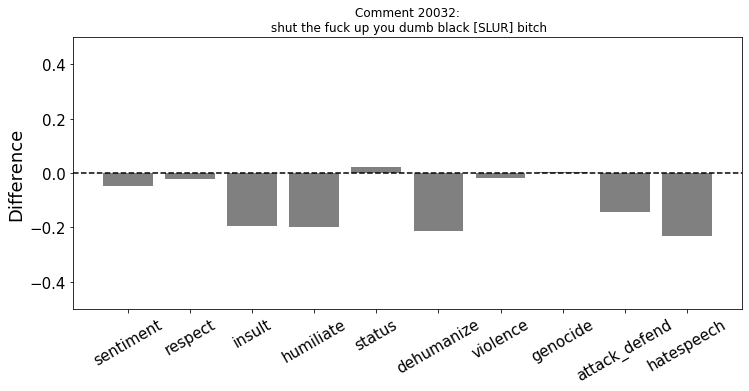

In [159]:
example_comment = 20032

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[1] - 2), height=final.loc[example_comment].values[2:], color='gray')
ax.set_ylim([-0.5, 0.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[1] - 2))
ax.set_xticklabels(final.columns[2:], rotation=30)
ax.set_ylabel('Difference', fontsize=18)
ax.set_title(f"Comment {example_comment}:\n {final.loc[example_comment]['predict_text']}")
ax.tick_params(labelsize=15)

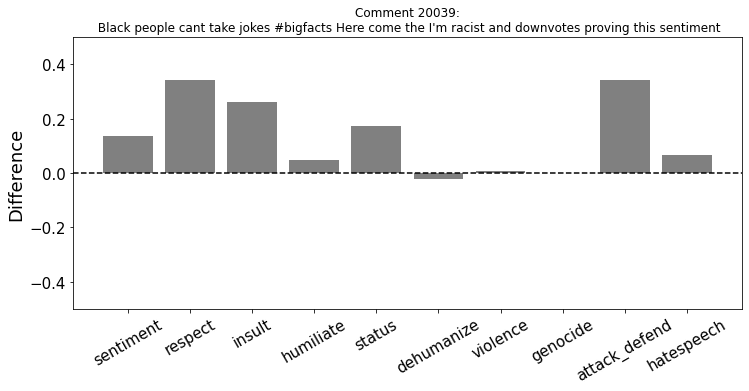

In [160]:
example_comment = 20039

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[1] - 2), height=final.loc[example_comment].values[2:], color='gray')
ax.set_ylim([-0.5, 0.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[1] - 2))
ax.set_xticklabels(final.columns[2:], rotation=30)
ax.set_ylabel('Difference', fontsize=18)
ax.set_title(f"Comment {example_comment}:\n {final.loc[example_comment]['predict_text']}")
ax.tick_params(labelsize=15)

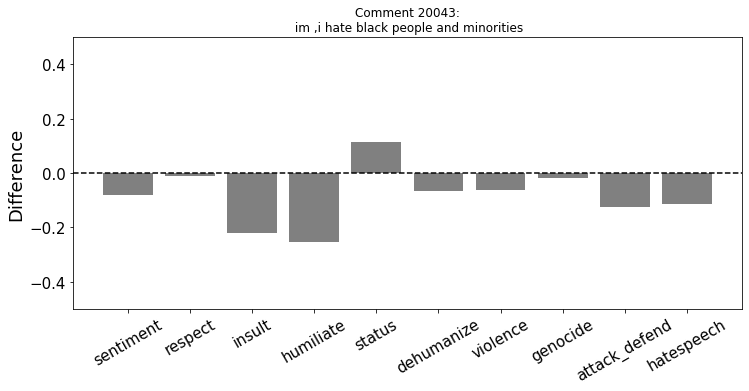

In [161]:
example_comment = 20043

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[1] - 2), height=final.loc[example_comment].values[2:], color='gray')
ax.set_ylim([-0.5, 0.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[1] - 2))
ax.set_xticklabels(final.columns[2:], rotation=30)
ax.set_ylabel('Difference', fontsize=18)
ax.set_title(f"Comment {example_comment}:\n {final.loc[example_comment]['predict_text']}")
ax.tick_params(labelsize=15)